# Data Visualization

In [1]:
import os
task_dir = 'C:\\Users\\jchen\\Desktop\\Datasets\\Heart_Isensee\\'
input_dir = task_dir + 'imagesTr\\'
labels_dir = task_dir + 'labelsTr\\'
data_dirs = [input_dir, labels_dir]
list_IDs = os.listdir(input_dir)


In [5]:
import matplotlib.pyplot as plt
def plotScan(scan, start_with, show_every, rows=3, cols=3, box = None):    
    fig,ax = plt.subplots(rows, cols, figsize=[3*cols,3*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols), int(i%cols)].set_title('slice %d' % ind)
        ax[int(i/cols), int(i%cols)].axis('off')
        
        #Draw the scan cropping to the provided box
        if box:
            clipScan = scan[ind,box[2]-1:box[5],
                            box[1]-1:box[4]]
            ax[int(i/cols), int(i%cols)].imshow(clipScan,cmap='gray')
        else:
            ax[int(i/cols), int(i%cols)].imshow(scan[ind],cmap='gray')
    plt.show()

Shape:  (119, 231, 319)


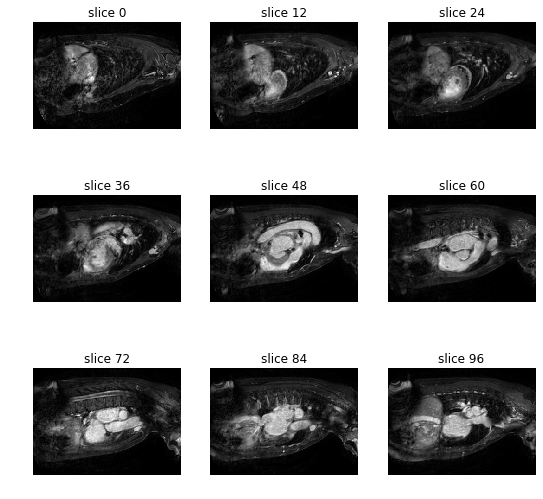

In [24]:
import nibabel as nib
import numpy as np
# arr = nib.load(os.path.join(task_dir, input_dir, list_IDs[1])).get_fdata()
# arr = np.transpose(arr, [-1, 0,1])
arr = np.load(os.path.join(task_dir, input_dir, list_IDs[1]))
print("Shape: ", arr.shape)
every_ = 12
plotScan(arr.squeeze(), 0, every_)
# plotScan(y[batch_].squeeze(), 0, every_)

In [48]:
arr_list = []
for p_id in list_IDs:
    arr = np.load(os.path.join(task_dir, input_dir, p_id))
    arr_shape = np.asarray(arr.shape)
    print("Shape appended: ", arr_shape)
    arr_list.append(arr_shape)
stacked_shapes = np.stack(arr_list)
mean_shape = np.mean(stacked_shapes, axis = 0)
max_shape = np.max(stacked_shapes, axis = 0)
print("Mean Shape: ", mean_shape, "Max Shape: ", max_shape)

Shape appended:  [141 231 319]
Shape appended:  [119 231 319]
Shape appended:  [130 231 319]
Shape appended:  [141 243 319]
Shape appended:  [108 231 314]
Shape appended:  [130 231 319]
Shape appended:  [130 231 319]
Shape appended:  [130 255 319]
Shape appended:  [ 97 195 315]
Shape appended:  [130 231 319]
Shape appended:  [132 231 319]
Shape appended:  [108 223 319]
Shape appended:  [119 199 319]
Shape appended:  [108 227 319]
Shape appended:  [119 243 319]
Shape appended:  [119 231 319]
Shape appended:  [130 231 319]
Shape appended:  [130 231 319]
Shape appended:  [118 231 319]
Shape appended:  [119 223 319]
Mean Shape:  [ 122.9   229.    318.55] Max Shape:  [141 255 319]


# Testing Actual Generators

In [3]:
import keras_med_io
from keras_med_io.transforms.transforms_generator import *
import os
import numpy as np
import batchgenerators
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.abstract_transforms import Compose
from keras_med_io.utils.transforms_utils import compute_pad_value

task_dir = 'C:\\Users\\jchen\\Desktop\\Datasets\\Heart_Isensee\\'
input_dir = task_dir + 'imagesTr\\'
labels_dir = task_dir + 'labelsTr\\'
data_dirs = [input_dir, labels_dir]
list_IDs = os.listdir(input_dir)

Using TensorFlow backend.


In [2]:
batch_size = 2
mean_patient_shape = (batch_size, 1, 123, 230, 320)
patch_shape = (80, 192, 128)
# brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
border_cval = compute_pad_value(input_dir, list_IDs)
spatial_transform = SpatialTransform(patch_shape, #mean_patient_shape[2:], 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.8, 2.), 
                 border_mode_data='constant', border_cval_data= border_cval, 
                 order_data=1, random_crop=True)

mirror_transform = MirrorTransform(axes=(1, 2))
transforms_list = [spatial_transform, mirror_transform]
composed = Compose(transforms_list)

Computing min/pad value...


## 3D Data Generation

In [6]:
# purposely excluding max_patient_shape; it's automatically found
gen = Transformed3DGenerator(list_IDs, data_dirs, batch_size = batch_size, n_channels = 1, n_classes = 1, ndim = 3, \
                             transform = composed)

Computing shape statistics...
Max Patient Shape:  (141, 255, 319) 
Mean Patient Shape:  (122.90000000000001, 229.0, 318.55000000000001) 
Min Patient Shape:  (97, 195, 314)


In [7]:
x, y = gen.__getitem__(1)
x.shape, y.shape

((2, 80, 192, 128, 1), (2, 80, 192, 128, 1))

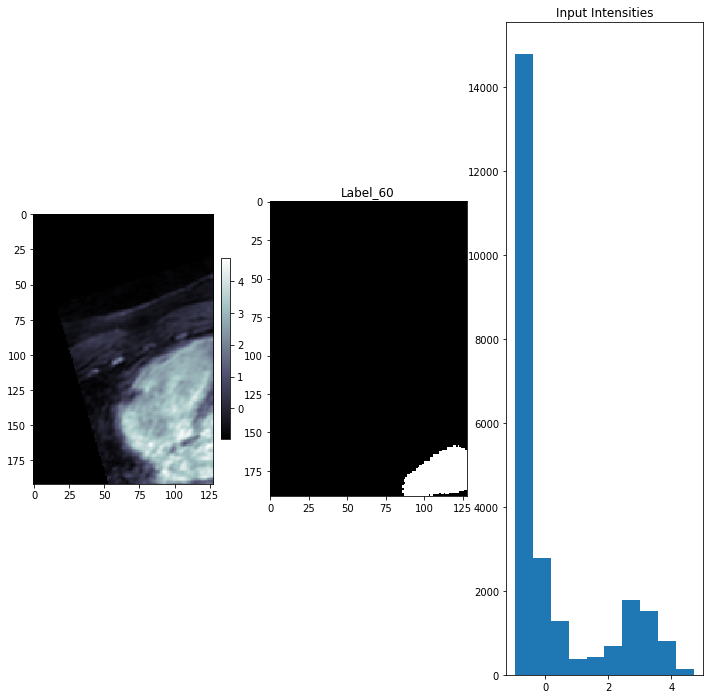

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_pred_3d(batch, i, inputs, labels, pred = None, cnn = True):
    '''
    i: integer for slice #
    pred: outputted segmentation
    reconstruct: reconstruction of positive input class 
    '''
    if cnn:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (12,12))
        img = ax1.imshow(inputs[batch][i].squeeze(), cmap = 'bone')
        #     # create an axes on the right side of ax. The width of cax will be 5%
        #     # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        #     divider = make_axes_locatable(ax1)
        #     cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img, fraction=0.046, pad=0.04, ax= ax1)

        ax2.imshow(labels[batch][i].squeeze(), cmap = 'bone') 
        ax2.set_title('Label_'+str(i))
        if pred is not None:
            ax3.imshow(pred[batch][i].squeeze(), cmap = 'bone')
            ax3.set_title('Segmentation_'+str(i))
        elif pred is None:
            ax3.hist(inputs[batch][i].ravel())
            ax3.set_title("Input Intensities")

    else:
        fig, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(1, 5, figsize= (20,20))


        img = ax1.imshow(inputs[0][i].squeeze(), cmap = 'bone')
        #     # create an axes on the right side of ax. The width of cax will be 5%
        #     # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        #     divider = make_axes_locatable(ax1)
        #     cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img, fraction=0.046, pad=0.04, ax= ax1)

        ax2.imshow(labels[0][i].squeeze(), cmap = 'bone') 
        ax2.set_title('Label_'+str(i))

        ax3.imshow(pred[0][i].squeeze(), cmap = 'bone')
        ax3.set_title('Segmentation_'+str(i))

        ax4.imshow(labels[1][i].squeeze(), cmap = 'bone')
        ax4.set_title('Positive Mask')

        ax5.imshow(pred[1][i].squeeze(), cmap = 'bone') 
        ax5.set_title('Reconstruction_'+str(i))

show_pred_3d(1, 60, x, y)

In [9]:
def plotScan(scan, start_with, show_every, rows=3, cols=3, box = None):    
    fig,ax = plt.subplots(rows, cols, figsize=[3*cols,3*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols), int(i%cols)].set_title('slice %d' % ind)
        ax[int(i/cols), int(i%cols)].axis('off')
        
        #Draw the scan cropping to the provided box
        if box:
            clipScan = scan[ind,box[2]-1:box[5],
                            box[1]-1:box[4]]
            ax[int(i/cols), int(i%cols)].imshow(clipScan,cmap='gray')
        else:
            ax[int(i/cols), int(i%cols)].imshow(scan[ind],cmap='gray')
    plt.show()

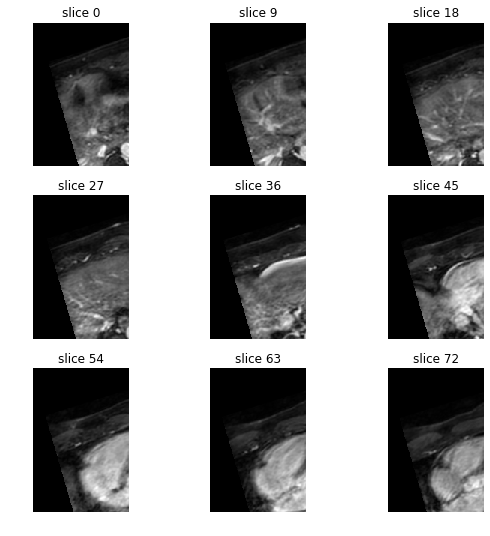

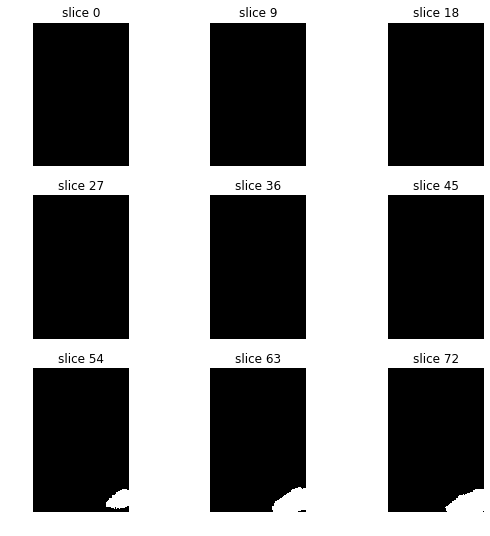

In [10]:
# inputs, labels = gen_3D_val.__getitem__(0)
# inputs, labels = gen_3D.__getitem__(1)
batch_ = 1
every_ = 9
plotScan(x[batch_].squeeze(), 0, every_)
plotScan(y[batch_].squeeze(), 0, every_)

## 2D Data Generation

In [1]:
import keras_med_io
from keras_med_io.transforms.transforms_generator import *
import os
import numpy as np
import batchgenerators
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.abstract_transforms import Compose
from keras_med_io.utils.transforms_utils import compute_pad_value

task_dir = 'C:\\Users\\jchen\\Desktop\\Datasets\\Heart_Isensee\\'
input_dir = task_dir + 'imagesTr\\'
labels_dir = task_dir + 'labelsTr\\'
data_dirs = [input_dir, labels_dir]
list_IDs = os.listdir(input_dir)

Using TensorFlow backend.


In [2]:
batch_size = 2
mean_patient_shape = (batch_size, 1, 123, 230, 320)
patch_shape = (256, 320)
# brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
border_cval = compute_pad_value(input_dir, list_IDs)
spatial_transform = SpatialTransform(patch_shape, #mean_patient_shape[2:], 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.8, 2.), 
                 border_mode_data='constant', border_cval_data= border_cval, 
                 order_data=1, random_crop=True)

mirror_transform = MirrorTransform(axes=(1, 2))
transforms_list = [spatial_transform, mirror_transform]
composed = Compose(transforms_list)

Computing min/pad value...


In [3]:
# purposely excluding max_patient_shape; it's automatically found
batch_size = 9
n_pos = round(batch_size // 3)
print("Number of positive slices: ", n_pos)
gen = Transformed2DGenerator(list_IDs, data_dirs, batch_size = batch_size, n_channels = 1, n_classes = 1, ndim = 2, \
                             n_pos = n_pos, transform = composed, max_patient_shape = (256, 320))

Number of positive slices:  3


In [4]:
x, y = gen.__getitem__(1)
x.shape, y.shape

((9, 256, 320, 1), (9, 256, 320, 1))

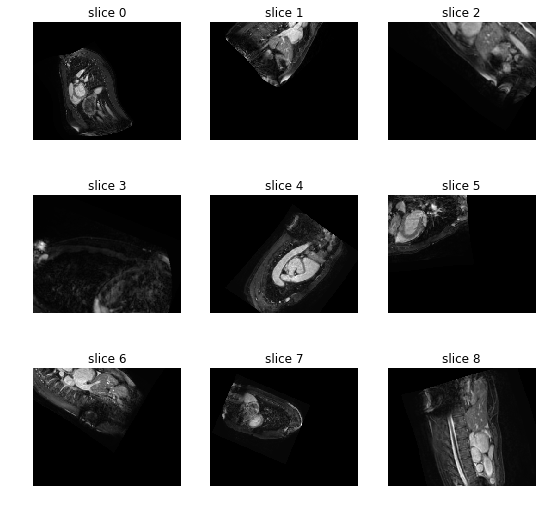

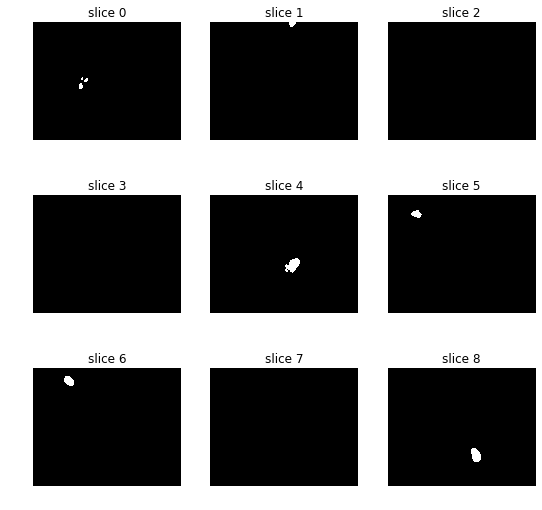

In [6]:
# inputs, labels = gen_3D_val.__getitem__(0)
# inputs, labels = gen_3D.__getitem__(1)
batch_ = 1
every_ = 1
plotScan(x.squeeze(), 0, every_)
plotScan(y.squeeze(), 0, every_)